<a href="https://colab.research.google.com/github/TorbjornLarsson/SMI/blob/main/lab/ResNet_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet
ResNet stands for Residual Network. It's a type of convolutional neural network (CNN) architecture that was introduced in 2015 by researchers at Microsoft, and it won the [ImageNet](https://en.wikipedia.org/wiki/ImageNet) competition that year. If you are interested, you can read the original paper here: [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385).  

When you make a CNN deeper (by stacking more layers), you expect it to perform better because deeper networks can learn more complex features. However, in practice it could in fact become worse. ResNet's main innovation is the use of residual connections, a clever trick to address this problem.

Instead of learning the direct mapping $y = \mathcal{H}(x)$ as in fully-connected networks, ResNets learns what has to be added to the input to get the output. That is, the **residual** $\mathcal{F}(x)$ where

\begin{align}
\mathcal{F}(x) =& \;\mathcal{H}(x) - x \\
\mathcal{F}(x) + x =&\; \mathcal{H}(x)
\end{align}

In practice, this is achieved through residual connections which acts as "short-cuts" for the input $x$. A residual block is defined as;

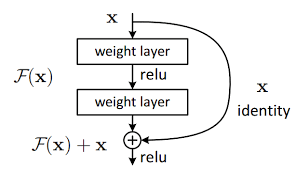

where the weight layers can be convolutional layers. As you can see, the input $x$ skips the weight layers and get added to the residual $\mathcal{F}(x)$ at the end of the block. A full ResNet model is built by sequentially stacking these blocks one after another.

Authors: Stina Brunzell, Albin Åberg Dahlberg, Paul Häusner <br>
Last update: 05.12.2024


# Real world image classification

This notebook classifies real world images using ResNet-18 pretrained on [ImageNet](https://en.wikipedia.org/wiki/ImageNet). The integer 18 indicates that this ResNet has 18 layers:

- 1 initial convolutional layer.
- Each residual block consists of 2 convolutional layers. There are 8 sequential residual blocks in the model.
- The final layer is a fully connected layer generating class predictions.

$$1 + 2\cdot 8 + 1 = 18$$

In [1]:
# Import libraries
%matplotlib inline
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import timm

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import json
from urllib.request import urlopen
from urllib.error import URLError

We start by loading the model from a library called timm, short for PyTorch Image Models.

In [2]:
resnet = timm.create_model(model_name='resnet18', pretrained=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

We switch the network to evaluation mode (that disables dropout and other features specific for training) and print a summary of the network architecture.

In [3]:
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

The pretrained ResNet model [expects](https://pytorch.org/docs/master/torchvision/models.html#classification)
>  input images normalized in the same way as during training, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of `[0, 1]` and then normalized using `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]`.

Thus we define the following set of preprocessing steps, that resizes an input image, crops it to the requested size, converts the pixels to values in [0, 1], and then normalizes them accordingly.

In [4]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

To be able to analyze the predictions of the model, we load [curated list of human-readable labels](https://github.com/anishathalye/imagenet-simple-labels) for the 1000 classes of the ImageNet dataset with which the model has been trained.

In [5]:
with urlopen('https://git.io/JvBFb') as f:
    LABELS = json.load(f)

We load an image that we want to classify, either from a local folder or the internet.

RGB image of size (1006, 668)


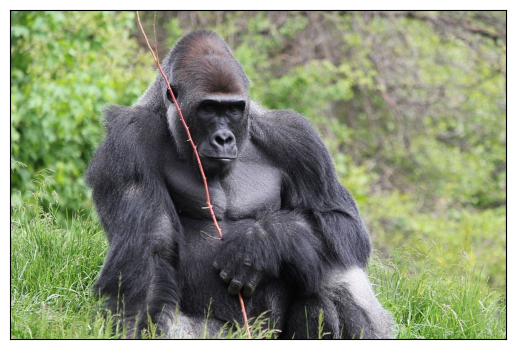

In [6]:
# URL of the image that we want to analyze
# prepend 'file:' to local paths (e.g., use 'file:./gorilla.jpeg')
image_url = 'https://media.arto.se/app/uploads/sites/6/2018/04/08125400/1200px-Western_Lowland_Gorilla_192.jpg'

# some examples from Google:
# Gorilla https://media.arto.se/app/uploads/sites/6/2018/04/08125400/1200px-Western_Lowland_Gorilla_192.jpg
# Uppsala cathedral https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fthumbs.dreamstime.com%2Fb%2Fuppsala-cathedral-sweden-dates-to-late-th-century-height-metres-tallest-church-nordic-countries-265773903.jpg&f=1&nofb=1&ipt=d29e15d0cd0d7c20282ff012624f612e0f3c037682c85c4d6efd3d4b522259a4
# African bush elephant https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fcdn.britannica.com%2F72%2F272-050-E1965E27%2FAfrican-elephant-Kenya.jpg&f=1&nofb=1&ipt=9b471f3dbee97287f812eb68c6c220c0761de59bd1fa8132ded8abe44a59e52a
# Pelle Svanslös https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fimage.tmdb.org%2Ft%2Fp%2Foriginal%2FwDOTURnv9PnZrLcF47a7B9wX2SZ.jpg&f=1&nofb=1&ipt=0976094981b540f36820d32864f88bb6857cd1bd35c58b76d6fc2b4e30c2aef0
# Hedgehog https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse1.mm.bing.net%2Fth%2Fid%2FOIP.AJ3kfu-DhAHkS9nsQ2Iu9wHaGn%3Fpid%3DApi%26ucfimg%3D1&f=1&ipt=b2dc057cf28a05f1c611b15ad6f58a5d1332e8f497d2e9060ec6aa768aad1c2c
# Suspension bridge https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fcdn.britannica.com%2F68%2F170868-050-8DDE8263%2FGolden-Gate-Bridge-San-Francisco.jpg&f=1&nofb=1&ipt=79b28e16e2de64266e9932fffb22d1ddb3154a25a7b790002cecefd69f89ffe7

try:
    with Image.open(urlopen(image_url)) as im:
        # The following fixes some problems when loading images:
        # https://stackoverflow.com/a/64598016
        image = im.convert("RGB")
except (URLError, OSError):
    print("please provide a valid URL or local path")
else:
    print(f"{image.mode} image of size {image.size}")
    plt.imshow(np.asarray(image))
    plt.xticks([])
    plt.yticks([])
    plt.show()

We preprocess the image, retrieve the predicted probabilities from the ResNet model.

In [7]:
# perform the pre-processing and form a "batch" of one single image
X = preprocess(image).unsqueeze(0)

# obtain the predicted probabilities for the image
with torch.no_grad():
    G = F.softmax(resnet(X), dim=1)[0]

We plot the image and print the human-readable labels of the top 5 predictions.

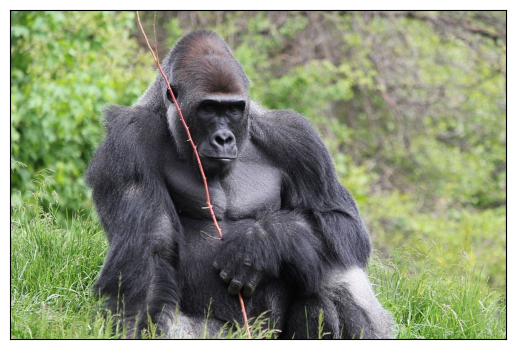

gorilla (100.00%)
macaque (0.00%)
chimpanzee (0.00%)
guenon (0.00%)
siamang (0.00%)


In [8]:
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.show()

for (p, y) in zip(*(G.topk(5))):
    print(f"{LABELS[y.item()]} ({100 * p.item():.2f}%)")

# Experiment with other ResNets
Try out other ResNet models (by changing `model_name` when loading the model) on a bunch of different images of your choice. Some exapmles of other ResNets are `resnet34`, `resnet50` and `resnet101`. Remember that the integer indicates the number of layers in the model.

What are your findings?